# Parameter Regression ML

## Problema in esame

La star-formation rate density (SFRD), ovvero il tasso di formazione stellare per unità di
volume, è una quantità che dipende, oltre che dall'età dell'Universo a cui la si misura
(ovvero il redshift), dal modello cosmologico ed astrofisico: $$SFRD = f(z, \vec{\theta})$$ dove $\vec{\theta}$ è il vettore di parametri cosmologici ed astrofisici da cui dipende la grandezza. Dunque dalla misura della SFRD a diversi redshift è possibile, in linea di principio, ricavare i parametri cosmologici ed astrofisici da cui dipende.

Data la difficoltà di derivare un modello analitico per $SFRD = f(z, \vec{\theta})$ vogliamo approssimare con una rete neuronale la funzione inversa $f^{-1}(SFRD(z))=\vec{\theta}$ che mappa la star-formation rate density nel set di parametri da cui essa dipende.

A questo scopo useremo le misure di SFRD(z) ricavate da un set di 1000 simulazioni idrodinamiche, ognuna ottenuta con un diverso set dei parameteri: $$\vec{\theta} = \left(\Omega_m, \sigma_8, A_{SN1}, A_{SN2}, A_{AGN1}, A_{AGN2}\right)$$ dove i primi due parametri sono parametri cosmologici legati alla densità di materia e all'ampiezza delle fluttuazioni del campo di materia a z=0, mentre i restati 4 parametri sono parametri astrofisici legati all'efficineza dei feedback energetici da espolosioni di supernovae e nuclei galattici attivi.

In [1]:
#import all the libraries
import numpy as np
import sys,os,time
import torch
import torch.nn as nn
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device('cuda')      #load model on GPU
else:
    print('CUDA Not Available')
    device = torch.device('cpu')       #else load model on CPU

CUDA Not Available


Il file SFRH_ IllustrisTNG.npy contiene i dati della SFRD(z), in unità di masse solari
per anno su $Mpc^3$, misurata in ogni simulazione ai valori di redshift: $$z = np.linspace(0.0, 7.0, 100)$$ mentre il file params_ IllustrisTNG.txt contiene i valori dei parametri $\vec{\theta}$ utilizzati per creare le simulazioni.

In [3]:
maps = np.load('SFRH_IllustrisTNG (1).npy')               #load SFRH(z) dataset
print(maps.shape)                                         #print the dataset dimension

params = np.loadtxt('params_IllustrisTNG (1).txt')        #load parameters dataset
print(params.shape)                                       #print the dataset dimension

(1000, 100)
(1000, 6)


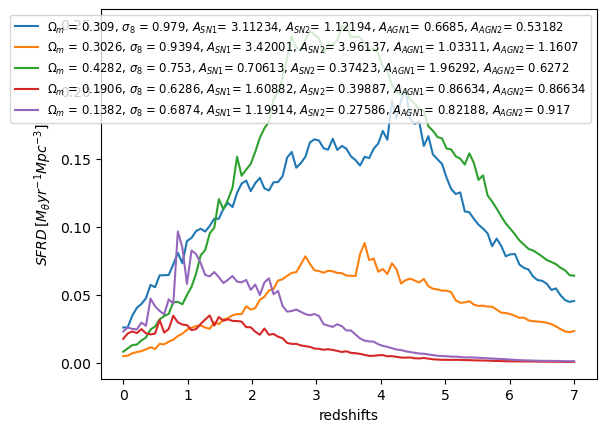

In [4]:
z = np.linspace(0.0, 7.0, 100)                          #redshifts of the SFRD

plt.ylabel(r'$SFRD\,[M_{\theta}yr^{-1}Mpc^{-3}]$')      #define the ylable 
plt.xlabel('redshifts')                                         #define the xlable

#plot the first 5 simulations in the SFRH dataset as a function of z
for i in range(5):            
    label = (rf'$\Omega_m$ = {params[i][0]}, $\sigma_8$ = {params[i][1]}, $A_{{SN1}}$= {params[i][2]}, '
             rf'$A_{{SN2}}$= {params[i][3]}, $A_{{AGN1}}$= {params[i][4]}, $A_{{AGN2}}$= {params[i][5]}')
    plt.plot(z, maps[i], label=label)
plt.legend(loc = 'best', fontsize = 'small')
plt.show()

## Hyper-parameters

Per la scelta degli hyper-parameters è stato usato un approccio iterativo e sperimentale. Si è fatta una ricerca randomizzata su una gamma di valori ragionevoli per ogni parametro. é stato utilizzato questo metodo dato il grande numero di hyper-parameters. 


- Per la _batch_size_ si è utilizzata una potenza di 2 per sfruttare le ottimizzazioni hardware offerte da pytorch. Con una batch_size di 32 si sono ottenuti degli ottimi risultati per il modello a costo però di aumentare il tempo utilizzato nel ciclo di allenamento.


- Per il _learning rate_ si sono utilizzati valori logaritmici partendo da valori grandi (0.1) e diminuendo sempre di una potenza di 10. Learning rate troppo alti hanno portato ad un training instabile metre lr troppo piccolo può causare un overfitting dei dati. Utilizzando la funzione lr_scheduler si è scelto un lr di $10^{-3}$ così da avere una ascesa nella funzione di loss grande all'inizio e più piccola quando si è vicini ad un minimo.


- Per il _dropout rate_ si sono scelti valori nell'intervallo $[0.2-0.5]$. Tramite un dr di 0.2 si sono ottenuti valori del modello migliori.


- Il numero di _epoche_ è stato inizialmente lasciato invariato a 1000. Dopo aver ottimizzato tutti gli altri hyperparameters, si è osservato dove partiva il plateau nella funzione di loss in funzione delle epoche. Si è quindi scelto di tranciare in modo ragionevole in numero di epoche per non causare problemi di overfitting.


- Per il valore di _patience_ si sono scelti valori in un intervallo di $[50-200]$, scendere sotto 50 potrebbe causare problemi di overfitting o allungare itempi di allenamento. Valori oltre al 200 non sono utilizzabili perchè non provocano miglioramenti del learning rate. Valori piccoli di patience hanno dato risultati migliori.


- Per il valore di _stop criterion_ si è scelto un valore più grande della patience per date al modello il tempo di migliorarsi dopo aver cambiato il learning rate.


- La architettura del modello trovato che mitiga il problema al meglio è costituito da due _hidden layer_ entrambi con una _hidden size_ di 109 neuroni. Per la scelta dell'architettura del modello si è cercato di prevenire al meglio il problema dell'overfitting dei dati. Si è notato che un valore di hidden size maggiore di 200 causava tale problema, si è scelto quindi un valore contenuto. Per il numero di hidden layer si è visto che un numero maggiore a 2 non portava rilevanti miglioramenti al modello. Non sono state notate differenze nell'utilizzo della funzione di attivazione ReLu da LeakyReLu. 

In [5]:
seed           = 2                   #random seed used to shuffel data before splitting
min_valid_loss_param = 1e10          #Used as threshold to save trained models    
#define hyperparameters
batch_size     = 32                  #number of training samples in one training iteration    
lr             = 1e-3                #learning rate
dr             = 0.2                 #dropout rate
wd             = 2e-4                #weight decay       
epochs         = 150                 #number of training iterations   
patience       = 50                  #number of epochs before improving learning rate    
stop_criterion = 100                 #number of epochs before stopping training cycle      
hidden_size    = 109                 #size of hidden layer      
f_model = 'best_model.pt'            #data of best model

In [6]:
#create dataset using the make_dataset class
def create_dataset(mode, x, y, batch_size, seed):
    
    #create a make_dataset class with the dataset
    data_set = make_dataset(mode, x, y, seed)
    
    #create the DataLoader
    return DataLoader(dataset=data_set, batch_size=batch_size, shuffle=True)

In [7]:
#define the make_dataset class
class make_dataset():

    def __init__(self, mode, x, y, seed):

        #Standardize the input
        mean = np.mean(x, axis=0)
        std  = np.std(x,  axis=0)
        x = (x - mean)/std
        
        #Normalize the output
        min_y = np.min(y, axis=0)
        max_y = np.max(y, axis=0)
        y     = (y - min_y)/(max_y - min_y)
        
        #Get the number of data 
        n_training = x.shape[0]

        #Depending on the use get the size and offset of the dataset 
        if   mode=='train':
            size, offset = int(n_training*0.70), int(n_training*0.00)
        elif mode=='valid':
            size, offset = int(n_training*0.15), int(n_training*0.70)
        elif mode=='test':
            size, offset = int(n_training*0.15), int(n_training*0.85)
        elif mode=='all':
            size, offset = int(n_training*1.00), int(n_training*0.00)
        else:    
            raise Exception('Wrong name!')

        #define the input and output array size    
        self.size   = size
        self.input  = torch.zeros((size,100), dtype=torch.float) 
        self.output = torch.zeros((size,6),    dtype=torch.float) 

        #shuffle the data
        np.random.seed(seed)
        indexes = np.arange(n_training)
        np.random.shuffle(indexes)
        indexes = indexes[offset:offset+size] 

        #fill the input and output array with the shuffled datta
        self.input  = torch.tensor(x[indexes], dtype=torch.float32)
        self.output = torch.tensor(y[indexes], dtype=torch.float32)
        self.output = self.output.unsqueeze(1)

    #returns the size of the datatset    
    def __len__(self):
        return self.size

    #returns a choosen input and output
    def __getitem__(self, idx):
        return self.input[idx], self.output[idx]

In [8]:
train_loader = create_dataset('train', maps, params , batch_size, seed)     #get the training dataset
valid_loader = create_dataset('valid', maps, params, batch_size, seed)      #get the validation datatset

In [9]:
#define the NN model using nn.Sequential
#define the number of hidden layers and the activation function
model = nn.Sequential(
            nn.Dropout(dr),
            nn.Linear(100, hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size, 6))

model.to(device=device)                  #move model to GPU or CPU             

#network_total_params = sum(p.numel() for p in model.parameters())
#print('total number of parameters in the model = %d'%network_total_params)

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=100, out_features=109, bias=True)
  (2): LeakyReLU(negative_slope=0.01)
  (3): Linear(in_features=109, out_features=109, bias=True)
  (4): LeakyReLU(negative_slope=0.01)
  (5): Linear(in_features=109, out_features=109, bias=True)
  (6): LeakyReLU(negative_slope=0.01)
  (7): Linear(in_features=109, out_features=6, bias=True)
)

In [10]:
#define loss function, Mean Squared Error
loss_func = nn.MSELoss()
#define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.5, 0.999), weight_decay=wd)
#The Adam optimizer is an adaptive learning rate optimization algorithm 

In [11]:
start = time.time()

#save loss function values
train_value=np.zeros(epochs)
valid_value=np.zeros(epochs)

min_valid_loss=min_valid_loss_param

#updates the learning rate after the best model doesn't improve after patience epochs
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=patience, min_lr= 1.0e-7, verbose=True) 

#save the best model epoch
epoch_best_model = 0

#loop for every epoch
for epoch in range(epochs):

    #training loop
    train_loss, points = 0.0, 0
    model.train()                    #model is being used for training
    
    #loop over training data in batches
    for x_train, y_train in train_loader:  

        #get batch size
        bs = x_train.shape[0]

        #load data to device (GPU or CPU)
        y_train = y_train.to(device).squeeze(1)
        x_train   = x_train.to(device)

        #value predicted by NN
        y_pred  = model(x_train)

        #compute loss 
        loss = loss_func(y_pred, y_train)

        #compute average training loss
        train_loss += (loss.item())*bs
        points     += bs

        optimizer.zero_grad()       #set the gradient back to zero
        loss.backward()             #backpropagation
        optimizer.step()            #update the parameters

    #get the average training loss    
    train_loss /= points
    train_value[epoch]=train_loss

    #validation loop
    valid_loss, points = 0.0, 0
    model.eval()                          #model is being used for validation
    
    #loop over validation data in batches
    for x_val, y_val in valid_loader: 
        with torch.no_grad():             #no need to compute gradient during validation

            #get batch size
            bs = x_val.shape[0]

            #load data to device (GPU or CPU)
            y_val = y_val.to(device).squeeze(1)
            x_val   = x_val.to(device)

            #value predicted by NN
            y_pred = model(x_val)

            #compute loss function
            valid_loss += (loss_func(y_pred, y_val).item())*bs
            points     += bs

    #get the average validation loss
    valid_loss /= points
    valid_value[epoch]=valid_loss

    #give valid loss to scheduler
    scheduler.step(valid_loss) 

    print(f'epoch:{epoch}, valid loss: {valid_loss:.4f}', end='')
    
    #check for best model
    if valid_loss<min_valid_loss:
        torch.save(model.state_dict(), f_model)      #save model
        min_valid_loss = valid_loss                  #set new min_valid_loss
        epoch_best_model=epoch                       #save best model epoch
        print(' (best-model)')
    else:
        print('')

    #check if model has improved in the last stop_criterion epochs else break training cycle
    if epoch - epoch_best_model > stop_criterion:
        print ('Training stop at epoch:',epoch,' because the best model does not improved after ',stop_criterion,' epochs')
        break

#stop training cycle
stop = time.time()
print('Time taken (seconds):', "{:.4f}".format(stop-start))

epoch:0, valid loss: 0.0806 (best-model)
epoch:1, valid loss: 0.0688 (best-model)
epoch:2, valid loss: 0.0621 (best-model)
epoch:3, valid loss: 0.0616 (best-model)
epoch:4, valid loss: 0.0604 (best-model)
epoch:5, valid loss: 0.0570 (best-model)
epoch:6, valid loss: 0.0554 (best-model)
epoch:7, valid loss: 0.0562
epoch:8, valid loss: 0.0593
epoch:9, valid loss: 0.0564
epoch:10, valid loss: 0.0539 (best-model)
epoch:11, valid loss: 0.0563
epoch:12, valid loss: 0.0530 (best-model)
epoch:13, valid loss: 0.0544
epoch:14, valid loss: 0.0542
epoch:15, valid loss: 0.0526 (best-model)
epoch:16, valid loss: 0.0528
epoch:17, valid loss: 0.0528
epoch:18, valid loss: 0.0530
epoch:19, valid loss: 0.0526
epoch:20, valid loss: 0.0538
epoch:21, valid loss: 0.0518 (best-model)
epoch:22, valid loss: 0.0523
epoch:23, valid loss: 0.0523
epoch:24, valid loss: 0.0525
epoch:25, valid loss: 0.0526
epoch:26, valid loss: 0.0530
epoch:27, valid loss: 0.0513 (best-model)
epoch:28, valid loss: 0.0531
epoch:29, val

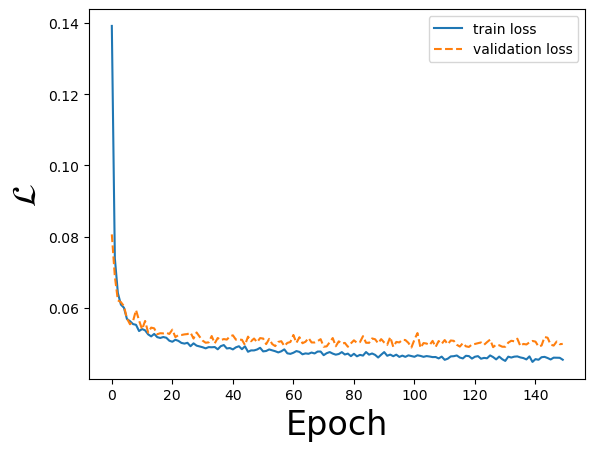

In [12]:
epoche=np.arange(epochs)           #number of epochs

plt.plot(epoche,train_value,label='train loss')                    #plot train loss
plt.plot(epoche,valid_value,ls='--',label='validation loss')       #plot validation loss

plt.xlabel("Epoch", fontsize=24)                   #name xlabel
plt.ylabel("$\mathcal{L}$", fontsize=24)           #name ylabel
plt.legend()
plt.show()

## Loss function

Dal grafico precedente si può notare una riduzione rapida nei primi 40 cicli di allenamento, questo mostra sta apprendendo dai dati e sta migliorando le sue predizioni. La trainig loss continua poi a diminuire in modo graduale ed arriva ad un plateau a circa 120 epoche. La validation loss tende a stabilizzarsi leggermente prima ma segue generalmente l'andamento della train loss. Ciò suggerisce che il modello sta generalizzando abbastanza bene i dati. è poi presente una leggera oscillazione nel processo di apprendimento causato probabilmente dall'utilizzo di un dropout rate.  

In [13]:
#test dataset
test_loader = create_dataset('test', maps, params, batch_size, seed)

#load best model
model.load_state_dict(torch.load(f_model))
model.to(device=device)


num_samples = len(test_loader.dataset)        #size of test datatset
num_inputs = 100                              #number of inputs
num_outputs = 6                               #number of outputs

#arrays to store input values, true and predicted output values
x_values = np.zeros((num_samples, num_inputs), dtype=np.float32)
y_true = np.zeros((num_samples, num_outputs), dtype=np.float32)
y_NN = np.zeros((num_samples, num_outputs), dtype=np.float32)

test_loss, points = 0.0, 0
model.eval()

#loop over batches
counter = 0
for x_test, y_test in test_loader:
    with torch.no_grad():               #no need to compute gradient
        bs = x_test.shape[0]            #get batch size

        #move data to device (GPU or CPU)
        x_test = x_test.to(device)
        y_test = y_test.to(device).squeeze(1)

        y_pred = model(x_test)          #get predicted values

        #need to move data to cpu and make a numpy array
        x_test_np = x_test.cpu().numpy()
        y_test_np = y_test.cpu().numpy().squeeze()  
        y_pred_np = y_pred.cpu().numpy().squeeze()  
        
        #store data
        x_values[counter:counter + bs, :] = x_test_np
        y_true[counter:counter + bs, :] = y_test_np
        y_NN[counter:counter + bs, :] = y_pred_np

        #compute loss
        test_loss += loss_func(y_pred, y_test).item() * bs
        points += bs

        counter += bs

test_loss /= points

print('test loss = %.3e' % test_loss)

test loss = 4.451e-02


In [14]:
#rescale values
#destantardize inputs
std = np.std(x_values)
mean = np.mean(x_values)
x_values = std*x_values + mean

#denormalize outputs
y_true= y_true*(np.max(params, axis=0)-np.min(params, axis=0))+np.min(params, axis=0)
y_NN= y_NN*(np.max(params, axis=0)-np.min(params, axis=0))+np.min(params, axis=0)

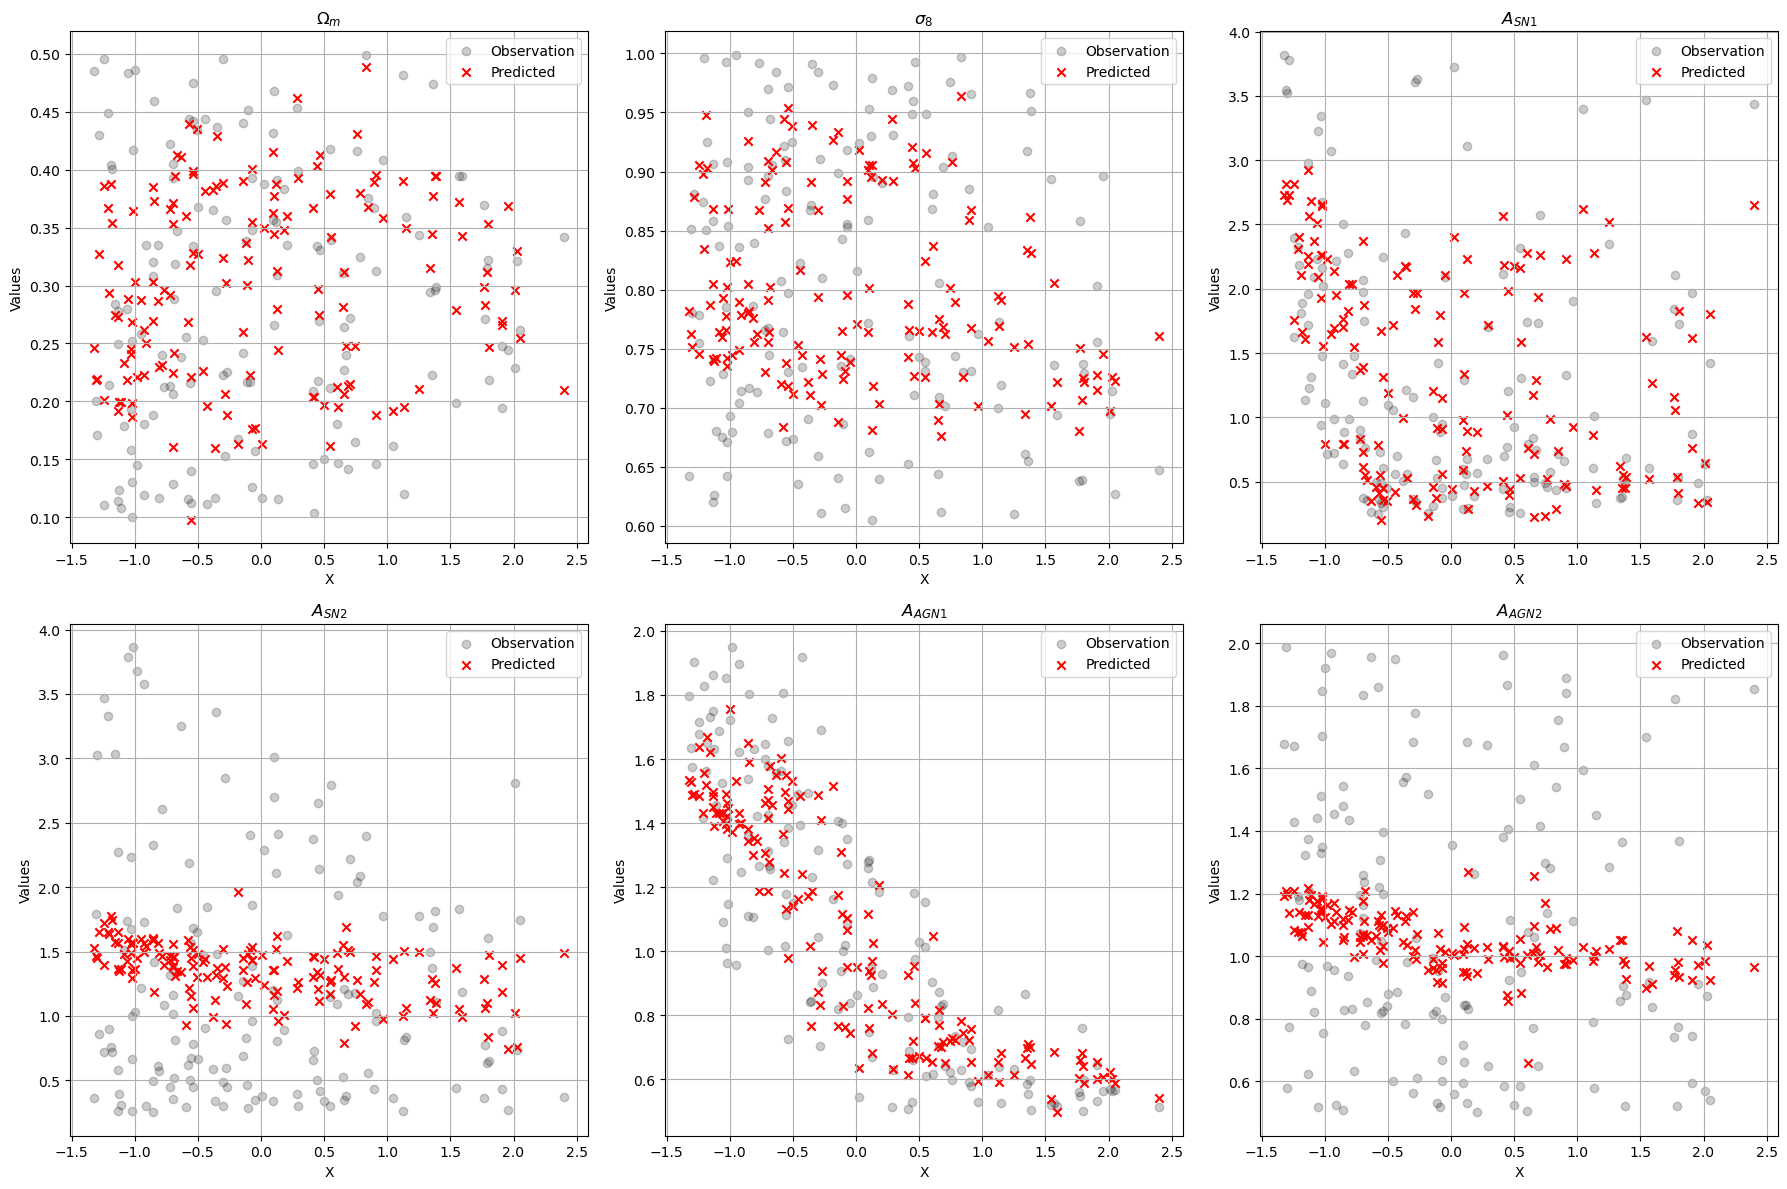

In [16]:
#create figure and set of subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

#define title names
param_names = ['$\Omega_m$', '$\sigma_8$', '$A_{SN1}$', '$A_{SN2}$', '$A_{AGN1}$', '$A_{AGN2}$']

#loop over number of parameters
for i in range(num_outputs):
    ax = axes[i]
    ax.scatter(x_values[:, 1], y_true[:, i], c='k', alpha=0.2, label='Observation')    #plot true datat
    ax.scatter(x_values[:, 1], y_NN[:, i], c='r', marker='x', label='Predicted')       #plot predicted data
    ax.set_xlabel('X')                  #define xlable
    ax.set_ylabel('Values')             #define ylable
    ax.set_title(param_names[i])        #define title name
    ax.grid(True)                       #show grid 
    ax.legend()                         #show legend
    
plt.tight_layout()
plt.show()

## Risultati

Da un'analisi generale dei grafici possiamo trarre che il modello è in grado di predirre alcune tendenze nei dati ma con una precisione non uniforme tra i diversi parametri.

**Analisi specifica per pannello**:
- $\Omega_m$ La sovrapposizione fra dati osservati e predetti è visibile ma non perfetta, il modello sembra comunque percepire la distribuzione dei dati.

- $\sigma_8$ I dati predetti sono compatibili in parte con quelli predetti, il modello sembra comunque percepire la distribuzione dei dati.

- $A_{SN1}$ La sovrapposizione fra dati osservati e predetti è molto buona , il modello sembra percepire bene la distribuzione dei dati

- $A_{SN2}$ Il grafico mostra una povera coincidenza fra dati predetti ed osservati, il modello non riesce a percepire solo in brevi tratti la distribuzione dei dati. Questo indica che il modello ha difficoltà a prevedere i parametri

- $A_{AGN1}$ I dati predetti sono compatibili con quelli osservati, la sovrapposizione fra i due è molto buona. Il modello riesce a percepire la distribuzione dei dati

- $A_{AGN2}$ I dati predetti non coincidono per la maggior parte con i dati osservati, il modello non riesce a percepire la distribuzione dei dati. Questo indica che il modello ha difficoltà a prevedere i parametri

**Considerazioni finali**

Le predizioni variano in accuratezza in funzione del parametro. Mentre alcuni parametri sono predetti con una certa precisione altri mostrano una dispersione significativa. Il modello è in grado di predirre la maggior parte dei parametri ma ha delle difficolta per $A_{SN2}$ e $A_{AGN2}$. Ciò può essere causato da vari fattori, tra i più probabili la non perfetta ottimizzazione degli hyper-parameters. Probabilmente una profonda ricerca per la ottimizzazione degli hyper-parameters e sperimentare con modelli più complessi potrebbe portare ad una migliore predizione dei parametri. Un secondo fattore può essere data dalla bontà dei dati utilizzati il che renderebbe difficile per la maggior parte dei modelli prevedere i parametri in modo accurato.